# Athleticism Metric#
<p> The statistic I will produce for this project will be a numerical representation of individual players’ athleticism. To create this statistic, I will pull measurements from specific aspects of the game that strongly represent athleticism, or represent more it more so than baseball specific skills. These measurements will be combined through a formula to determine rankings in three main categories; speed, strength, and acrobatic ability. The three of these categories will be combined to produce an athletic ability metric (ATH). Pitchers will be excluded from this metric.</p>

<p> Each catagory will be calculated indivdually, and weighted to produce a value that lies in a "video game range". This range is meant to put average rankings at 75 because we are reffering to professional athletes. Still, some players will lie far below this range in some catagories. </p>

In [137]:
#2018 Statcast Data pulled from Baseball Savant
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sb

# Speed Calculation#
<p> The speed metric, as broadcasted by the name, ranks players based on their sprint speed as well as splits for the first 10 and 30 feet of base running. These splits incorporate acceleration into the speed metric. Because of this added data, the metric will better evaluate the broader aspects that encompass speed that can help with stealing and fielding ability!</p>


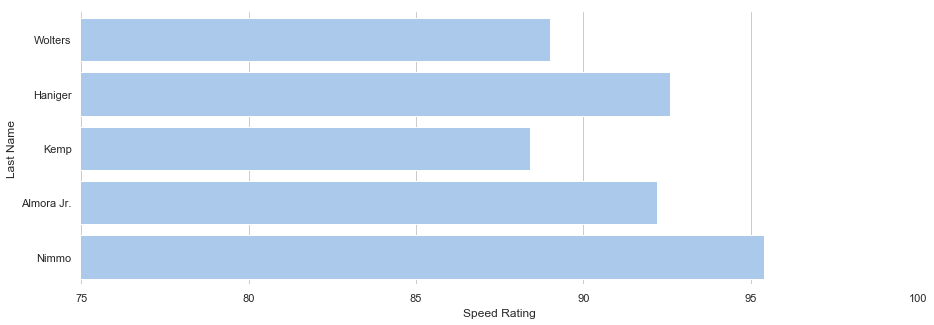

In [141]:
spd = pd.read_csv("sprint_speed.csv")
acc = pd.read_csv("running_splits.csv")

acc=acc[['last_name', 'player_id', 'seconds_since_hit_010', 'seconds_since_hit_030']]
#acc.sort_values(by='seconds_since_hit_010', ascending=True).head()

spd=spd[['last_name', 'player_id', 'sprint_speed']]
#spd.sort_values(by='sprint_speed', ascending=False).head()

acc=acc.merge(spd, how="left", on='player_id')
spd=acc[['last_name_x', 'player_id', 'seconds_since_hit_010', 'seconds_since_hit_030', 'sprint_speed']]
spd=spd.rename(index=str, columns={'last_name_x':'last_name'})

spd['SPD']=(50-spd['seconds_since_hit_010']*30)+(30-spd['seconds_since_hit_030']*10)+spd['sprint_speed']*2
spd.drop_duplicates(subset='player_id', keep='first', inplace=True)
spd=spd[['last_name', 'player_id', 'SPD']].sort_values(by='SPD', ascending=False)
spdgraph=spd.sample(5)

sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sb.set_color_codes("pastel")
sb.barplot(x="SPD", y="last_name", data=spdgraph, color="b")
ax.set(xlim=(75, 100), ylabel="Last Name", xlabel="Speed Rating")
sb.despine(left=True, bottom=True)

# Strength Calculation #
<p> The strength category is a metric based purely off batting power. Batting power is calculated by looking at the max exit velocity, exit velocity on fly balls and line drives, and percentage of hits that are hard hit (over 95mph). </p>

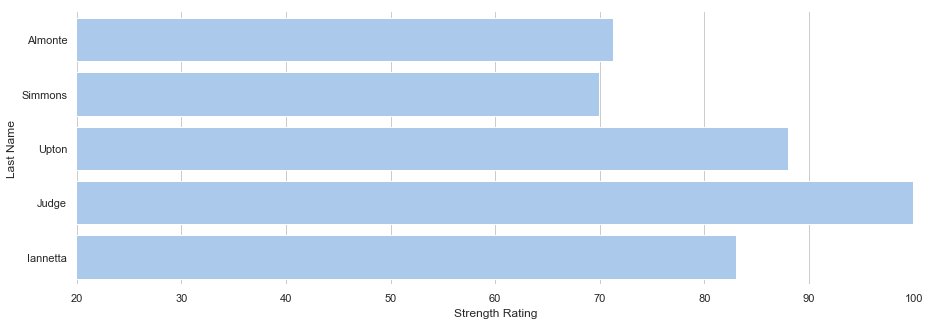

In [139]:
batting = pd.read_csv("exit_velocity.csv")

batting=batting[['last_name', 'player_id', 'max_hit_speed', 'fbld', 'ev95percent']]
batting['STR']=(batting['max_hit_speed']-95.8)+(batting['fbld']/3)+(batting['ev95percent']-10.8)
batting=batting[['last_name', 'player_id', 'STR']].sort_values(by='STR', ascending=False)
batg=batting.sample(5)

sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sb.set_color_codes("pastel")
sb.barplot(x="STR", y="last_name", data=batg, color="b")
ax.set(xlim=(20, 100), ylabel="Last Name", xlabel="Strength Rating")
sb.despine(left=True, bottom=True)

# Acrobatic Ability Calculation #
<p> The acrobatic ability metric will be used to represent the play making capabilities of players. This metric will be calculated for fielders and catchers seperately, as they do not have the same data sets. For field players, we will look at catch probabilities under 50%, 25%, and 10% and calculate the ratio of catches made to opportunities.  This stat alone will attempt to put a number on game changing plays, like robbing a home run or a diving in the infield. For catchers, we will look at pop and arm strength. Pop is the time it takes to throw the ball to second from the time it hits the catchers glove. </p>

In [140]:
fielding = pd.read_csv("catch_probability.csv")
pop=pd.read_csv("poptime.csv")

fielding=fielding[['last_name', 'player_id', 'n_5star_percent', 'n_4star_percent', 'n_3star_percent']]

fielding['ABL']=fielding['n_5star_percent']+(fielding['n_4star_percent']/2)+(fielding['n_3star_percent']/3)
fielding=fielding[['last_name', 'player_id', 'ABL']].sort_values(by='ABL', ascending=False)
#fielding.head()

pop=pop[['catcher', 'player_id', 'maxeff_arm_2b_3b_sba', 'pop_2b_sba']]
pop['ABL']=(pop['maxeff_arm_2b_3b_sba']/2)+(50-(pop['pop_2b_sba']*20))
pop=pop[['player_id', 'ABL']].sort_values(by='ABL', ascending=False)
#pop.head()

fielding=fielding.append(pop, sort=False)
fielding=fielding.sort_values(by='ABL', ascending=False)
fielding.drop_duplicates(subset='player_id', keep='first', inplace=True)
fielding['last_name'] = playerid_reverse_lookup(fielding['player_id'], key_type="mlbam")

Gathering player lookup table. This may take a moment.


[Text(0, 0.5, 'Last Name'),
 (0, 100),
 Text(0.5, 0, 'Play Making Ability Rating')]

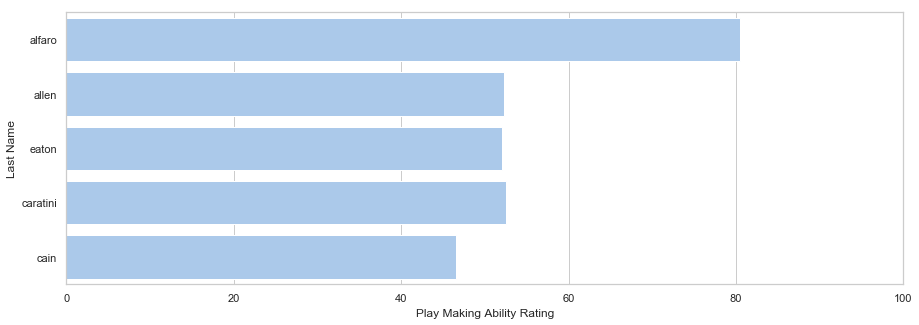

In [152]:
field=fielding.sample(5)
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sb.set_color_codes("pastel")
sb.barplot(x="ABL", y="last_name", data=field, color="b")
ax.set(xlim=(0, 100), ylabel="Last Name", xlabel="Play Making Ability Rating")

# Athleticism Calculation #


[Text(0, 0.5, 'Last Name'), (60, 100), Text(0.5, 0, 'Athleticism Rating')]

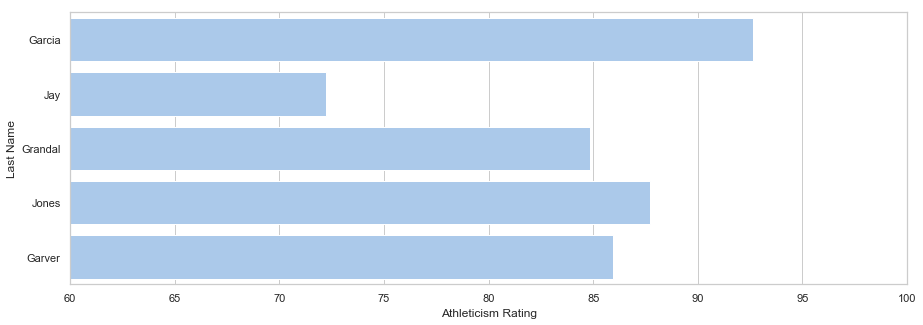

In [114]:
ath = fielding.merge(batting, how='left', on='player_id').merge(spd, how="left", on='player_id')
ath = ath[['last_name', 'player_id', 'ABL', 'STR', 'SPD']]
ath['ATH']=(ath['ABL']/6 + ath['STR']/2 + ath['SPD']/2)-4
ath=ath.dropna()
ath=ath.sort_values(by='ATH', ascending=False)
athg=ath.sample(5)

sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sb.set_color_codes("pastel")
sb.barplot(x="ATH", y="last_name", data=athg, color="b")
ax.set(xlim=(60, 100), ylabel="Last Name", xlabel="Athleticism Rating")

# Statistic Evaluation #
<p> There are no statistics looking directly at player athleticism available to the public. Because of this, I will compare my stat to Baseball References WAR statistic. WAR shows the statistical production of players, which is essentially a product of baseball skills and athleticism. Because my ATH stat shows player athleticism, it should correlate well with WAR. </p>

In [115]:
from scipy import stats
from pybaseball import bwar_bat
bWAR=bwar_bat()
bWAR=bWAR[bWAR['year_ID']==2018]
bWAR=bWAR[['mlb_ID', 'WAR']]
bWAR['player_id']=bWAR[['mlb_ID']]
bWAR=bWAR[['player_id', 'WAR']]
ath=ath.merge(bWAR, how='left', on='player_id')

In [116]:
import numpy as np

ath=ath.dropna(axis=0)
np.corrcoef(ath['ATH'], ath['WAR'])

array([[1.        , 0.50695648],
       [0.50695648, 1.        ]])

<p> The correlation coefficient between my ATH stat and Baseball Reference's WAR is 0.506, which, like I wrote above, shows that they are partially correlated. </p>

# Graph Comparison #

[Text(0, 0.5, 'Last Name'), (-2, 10), Text(0.5, 0, 'WAR')]

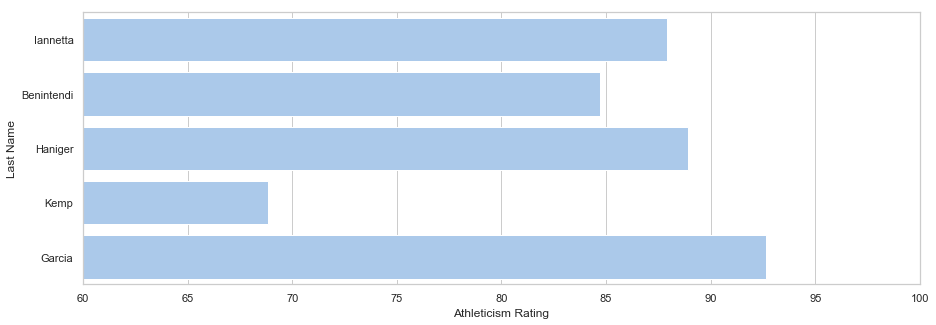

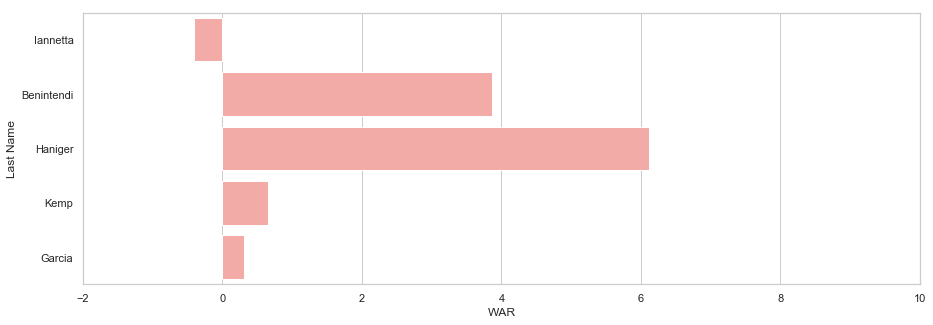

In [134]:
war=ath.sample(5)

sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sb.set_color_codes("pastel")
sb.barplot(x="ATH", y="last_name", data=war, color="b")
ax.set(xlim=(60, 100), ylabel="Last Name", xlabel="Athleticism Rating")

sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sb.set_color_codes("pastel")
sb.barplot(x="WAR", y="last_name", data=war, color="r")
ax.set(xlim=(-2, 10), ylabel="Last Name", xlabel="WAR")

# Regression Plot #

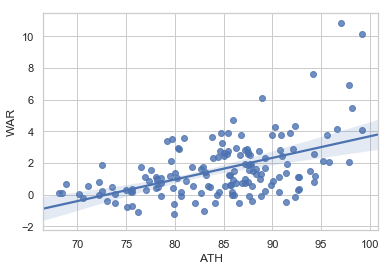

In [129]:
sb.regplot(x="ATH", y="WAR", data=ath);

<p> As shown in the above regression plot, my ATH metric correlates fairly well with WAR. The biggest discrepensies begin at ATH ratings above 85. I believe this is due to a broad range of baseball skills, like plate discipline, coming into play at this point. There is not so large a discrepensy in the lower half of my ATH stat because players with low athletic ability struggle to produce wins, even if they have strong baseball skills. </p>